[AAPL] Fetching data...


C:\Users\Hrichik\AppData\Local\Temp\ipykernel_2684\3117999139.py:28: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(self.symbol, start=self.start_date, progress=False)


✓ Data loaded: 3253 rows

--- PROFESSIONAL METRICS REPORT ---
Symbol         : AAPL
Return         : 124.67%
Sharpe         : 0.52
Max DD         : -22.89%
Max DD Days    : 810


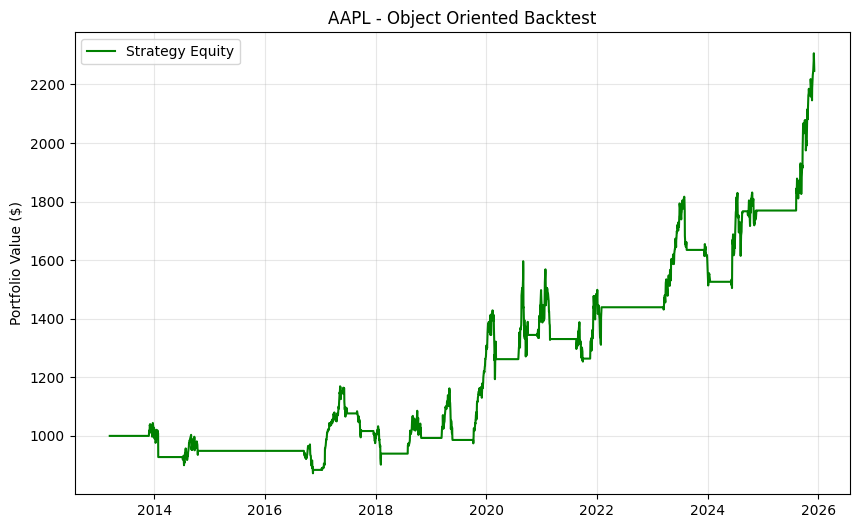

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure matplotlib graphs show up in Jupyter
%matplotlib inline 

class TradingStrategy:
    """
    A professional-grade backtesting engine for Trend+Momentum strategies.
    Encapsulates Data, Logic, and Performance Metrics in a modular object.
    """
    
    def __init__(self, symbol, start_date="2013-01-01", initial_capital=1000):
        self.symbol = symbol
        self.start_date = start_date
        self.initial_capital = initial_capital
        self.data = None
        self.results = None
        self.trades = None
        
    def fetch_data(self):
        """Fetches and cleans data from Yahoo Finance."""
        print(f"[{self.symbol}] Fetching data...")
        try:
            # Download data
            df = yf.download(self.symbol, start=self.start_date, progress=False)
            
            # Fix MultiIndex columns (common yfinance issue)
            if isinstance(df.columns, pd.MultiIndex):
                df.columns = df.columns.get_level_values(0)
            
            # Check if data is empty
            if df.empty:
                print(f"Error: No data found for {self.symbol}. Check ticker or date.")
                self.data = None
                return

            self.data = df.dropna()
            print(f"✓ Data loaded: {len(self.data)} rows")
            
        except Exception as e:
            print(f"Error fetching {self.symbol}: {e}")
            self.data = None
            
    def add_indicators(self):
        """Calculates technical indicators (SMA, MACD, Volume)."""
        if self.data is None: 
            return
        
        df = self.data.copy()
        
        # SMAs
        df['SMA20'] = df['Close'].rolling(20).mean()
        df['SMA50'] = df['Close'].rolling(50).mean()
        df['VolSMA20'] = df['Volume'].rolling(20).mean()
        
        # MACD
        exp1 = df['Close'].ewm(span=12, adjust=False).mean()
        exp2 = df['Close'].ewm(span=26, adjust=False).mean()
        df['MACD'] = exp1 - exp2
        df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
        
        self.data = df.dropna()

    def generate_signals(self):
        """Applies the trading logic to generate Entry/Exit signals."""
        if self.data is None:
            print("Skipping signals: No data loaded.")
            return

        df = self.data
        
        # Logic: Trend + Momentum + Volume
        trend_up = df['SMA20'] > df['SMA50']
        
        # MACD Crossover (Today > Signal AND Yesterday <= Signal)
        macd_cross = (df['MACD'] > df['Signal_Line']) & (df['MACD'].shift(1) <= df['Signal_Line'].shift(1))
        
        # Volume Confirmation
        vol_confirm = df['Volume'] > df['VolSMA20']
        
        # Create Signal Columns
        df['Entry'] = trend_up & macd_cross & vol_confirm
        df['Exit'] = df['SMA20'] < df['SMA50']
        
        self.data = df

    def run_backtest(self):
        """Simulates the trading loop."""
        if self.data is None:
            return

        if 'Entry' not in self.data.columns:
            self.generate_signals()
            
        cash = self.initial_capital
        shares = 0
        in_position = False
        equity_curve = []
        trade_log = []
        
        df = self.data
        
        for i in range(len(df)):
            price = df['Close'].iloc[i]
            date = df.index[i]
            
            # Buy
            if not in_position and df['Entry'].iloc[i]:
                shares = cash / price
                cash = 0
                in_position = True
                trade_log.append({'Type': 'Buy', 'Date': date, 'Price': price})
                
            # Sell
            elif in_position and df['Exit'].iloc[i]:
                cash = shares * price
                shares = 0
                in_position = False
                trade_log.append({'Type': 'Sell', 'Date': date, 'Price': price})
                
            # Mark to Market (Daily Value)
            current_val = cash + (shares * price)
            equity_curve.append(current_val)
            
        df['Equity'] = equity_curve
        self.results = df
        self.trades = pd.DataFrame(trade_log)
        
    def get_metrics(self):
        """Calculates professional risk/return metrics."""
        if self.results is None or self.results.empty: 
            return {"Error": "No results to analyze"}
        
        df = self.results
        df['Ret'] = df['Equity'].pct_change()
        
        total_ret = (df['Equity'].iloc[-1] / self.initial_capital) - 1
        sharpe = (df['Ret'].mean() / df['Ret'].std()) * (252**0.5) if df['Ret'].std() != 0 else 0
        
        # Max Drawdown
        cum_max = df['Equity'].cummax()
        drawdown = (df['Equity'] - cum_max) / cum_max
        max_dd = drawdown.min()
        
        # Drawdown Duration
        is_underwater = df['Equity'] < cum_max
        # Identify consecutive groups of True values
        dd_duration = is_underwater.groupby((is_underwater != is_underwater.shift()).cumsum()).cumsum().max()
        
        return {
            "Symbol": self.symbol,
            "Return": f"{total_ret*100:.2f}%",
            "Sharpe": f"{sharpe:.2f}",
            "Max DD": f"{max_dd*100:.2f}%",
            "Max DD Days": int(dd_duration) if not np.isnan(dd_duration) else 0
        }

# --- MAIN EXECUTION BLOCK ---
if __name__ == "__main__":
    # 1. Initialize
    strategy = TradingStrategy("AAPL")
    
    # 2. Run Pipeline
    strategy.fetch_data()
    strategy.add_indicators()
    strategy.generate_signals()
    strategy.run_backtest()
    
    # 3. Print Report
    print("\n--- PROFESSIONAL METRICS REPORT ---")
    metrics = strategy.get_metrics()
    for k, v in metrics.items():
        print(f"{k:<15}: {v}")
    
    # 4. Plot
    if strategy.results is not None:
        plt.figure(figsize=(10, 6))
        plt.plot(strategy.results.index, strategy.results['Equity'], label='Strategy Equity', color='green')
        plt.title(f"{strategy.symbol} - Object Oriented Backtest")
        plt.ylabel("Portfolio Value ($)")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()